In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common import NoSuchElementException, StaleElementReferenceException
from typing import Optional
import pickle
import csv
from selenium.webdriver.chrome.service import Service

In [4]:
import json
path = 'task1_train.jsonl'
data = []
with open(path, 'r') as fl:
    for line in fl:
        data.append(json.loads(line))

In [8]:
driver = webdriver.Edge()


In [9]:
def get_metadata(id: str):
    url = f'https://www.zora.uzh.ch/id/eprint/{id}/'
    print(f"navigating to {url}")
    driver.get(url)
    info = {}

    print("finding tables..")
    tables = driver.find_elements(By.CLASS_NAME, 'ep_block')
    print("finding rows..")
    table = tables[0]
    rows = table.find_elements(By.TAG_NAME, 'tr')

    # Iterate over the rows to extract the metadata.
    i = 0
    for row in rows:  # Skip the header row
        print(f"row {i} text: \'{row.text}\'.")
        # this is the key
        head = row.find_elements(By.TAG_NAME, 'th')[0].text
        # and this is the value
        cell = row.find_elements(By.TAG_NAME, 'td')[0].text
        info[head]=cell
        print(f"{head}: {cell}")
        i += 1
        # break
    return info

In [10]:
meta_data_fname = f'goals_metadata.json'

In [11]:
import os

if os.path.exists(meta_data_fname):
    with open(meta_data_fname, "r") as f:
        metas = json.load(f)
else:
    metas = {}
    
for i in range(len(data)):
    t = data[i]
    if metas.get(id) != None:
        continue
        
    id = t["ID"]
    actual_id = id.replace("oai:www.zora.uzh.ch:","")
    print(f"Processing paper {id} ({actual_id})")
    meta = get_metadata(actual_id)
    metas[id] = meta
    with open(meta_data_fname, "w") as fl:
        json.dump(metas, fl, indent=3)

In [12]:
len(metas)

430

In [13]:
# for each goal, gather the papers' categories that associate with that goal.

s = {}
for i in range(18):
    s[i]={}
    
for id, meta in metas.items():
    
    clf = [i for i in data if i["ID"] == id][0]
    sdg = int(clf["SDG"])
    
    for ml, mv in meta.items():
        if s[sdg].get(ml) is None:
            s[sdg][ml] = []
        
        b = mv.split('\n')
        for be in b:
            s[sdg][ml].append(be)


In [14]:
# now eliminate duplicate categories by turning the lists into sets.
for i in range(18):
    for ml, mvs in s[i].items():
        s[i][ml] = set(s[i][ml])

In [15]:
def my_add(w,k,v):
    if w.get(k) is None:
        w[k]={}
    
    w[k].append(v)

In [16]:
def rec_add(o, i, o2):
    k = o2[i]
    if o.get(k) is None:
        o[k]={}
        
    if i+1 >= len(o2):
        return o[k]
    else:
        return rec_add(o[k],i+1,o2)
    
def fill_for_goal(goal: int):
    G1 = s[goal]["Communities & Collections:"]
    G2 = s[goal]["Dewey Decimal Classification:"]
    G = list(G1)+list(G2)
    my_cats = {}
    for thing in G:
        parts = thing.split(' > ')
        rec_add(my_cats,0,parts)
    return my_cats

goals_categories = {}
for i in range(18):
    goals_categories[i] = fill_for_goal(i)


In [17]:
def rec_print(d: dict, i: str):
    next_i = i+"---"
    for k,v in d.items():
        print(i+k)
        rec_print(v,next_i)
def print_for_goal(goal: int):
    print(f"categories of papers of goal {goal}:")
    rec_print(goals_categories[goal],"")
print_for_goal(0)

categories of papers of goal 0:
03 Faculty of Economics
---Department of Informatics
---Department of Business Administration
---Department of Banking and Finance
---Center for Corporate Responsibility and Sustainability
---Department of Economics
---UBS Center for Economics in Society
07 Faculty of Science
---Institute of Molecular Cancer Research
---Department of Evolutionary Anthropology
---Zurich-Basel Plant Science Center
---Department of Chemistry
---Institute of Geography
---Institute of Molecular Life Sciences
---Physics Institute
---Department of Systematic and Evolutionary Botany
---Institute of Mathematics
---Department of Plant and Microbial Biology
---Institute of Pharmacology and Toxicology
---Institute for Computational Science
---Institute of Evolutionary Biology and Environmental Studies
06 Faculty of Arts
---Institute of Sociology
---Linguistic Research Infrastructure (LiRI)
---Institute of Psychology
---English Department
---Department of Communication and Media Rese

In [19]:
goals_cat_fname = "goals_categories.json"
with open(goals_cat_fname, "w") as f:
    json.dump(goals_categories, f, indent=3)

In [35]:
cats_by_pap_count = {}
for i in range(18):
    cats_by_pap_count[i] = {}
    
def inc(sdg: int, k):
    if cats_by_pap_count[sdg].get(k) != None:
        cats_by_pap_count[sdg][k] += 1
    else:
        cats_by_pap_count[sdg][k] = 1
        
for id,v in metas.items():
    clf = [i for i in data if i["ID"] == id][0]
    sdg = int(clf["SDG"])
    # G1 = s[goal]["Communities & Collections:"]
    # G2 = s[goal]["Dewey Decimal Classification:"]
    items = v["Communities & Collections:"]
    parents = []
    for item in items:
        parent = items.split(" > ")[0]
        # print("+1 for "+parent)
        parents.append(parent)
    parents = list(set(parents))
    for parent in parents:
        inc(sdg, parent)

In [36]:
for k, v in cats_by_pap_count.items():
    print(f"For goal {k}:")
    for c,v in v.items():
        print(f"{c}:{v}")

For goal 0:
06 Faculty of Arts:49
07 Faculty of Science:52
03 Faculty of Economics:24
National licences:1
05 Vetsuisse Faculty:11
04 Faculty of Medicine:17
08 Research Priority Programs:1
01 Faculty of Theology and the Study of Religion:1
For goal 1:
03 Faculty of Economics:3
07 Faculty of Science:3
For goal 2:
03 Faculty of Economics:2
05 Vetsuisse Faculty:1
07 Faculty of Science:7
04 Faculty of Medicine:1
For goal 3:
04 Faculty of Medicine:5
05 Vetsuisse Faculty:3
06 Faculty of Arts:1
03 Faculty of Economics:1
For goal 4:
03 Faculty of Economics:2
06 Faculty of Arts:2
For goal 5:
03 Faculty of Economics:8
06 Faculty of Arts:1
For goal 6:
06 Faculty of Arts:1
07 Faculty of Science:5
For goal 7:
07 Faculty of Science:14
03 Faculty of Economics:3
For goal 8:
03 Faculty of Economics:14
07 Faculty of Science:4
02 Faculty of Law:1
06 Faculty of Arts:2
For goal 9:
03 Faculty of Economics:7
02 Faculty of Law:2
For goal 10:
06 Faculty of Arts:14
03 Faculty of Economics:14
07 Faculty of Scienc

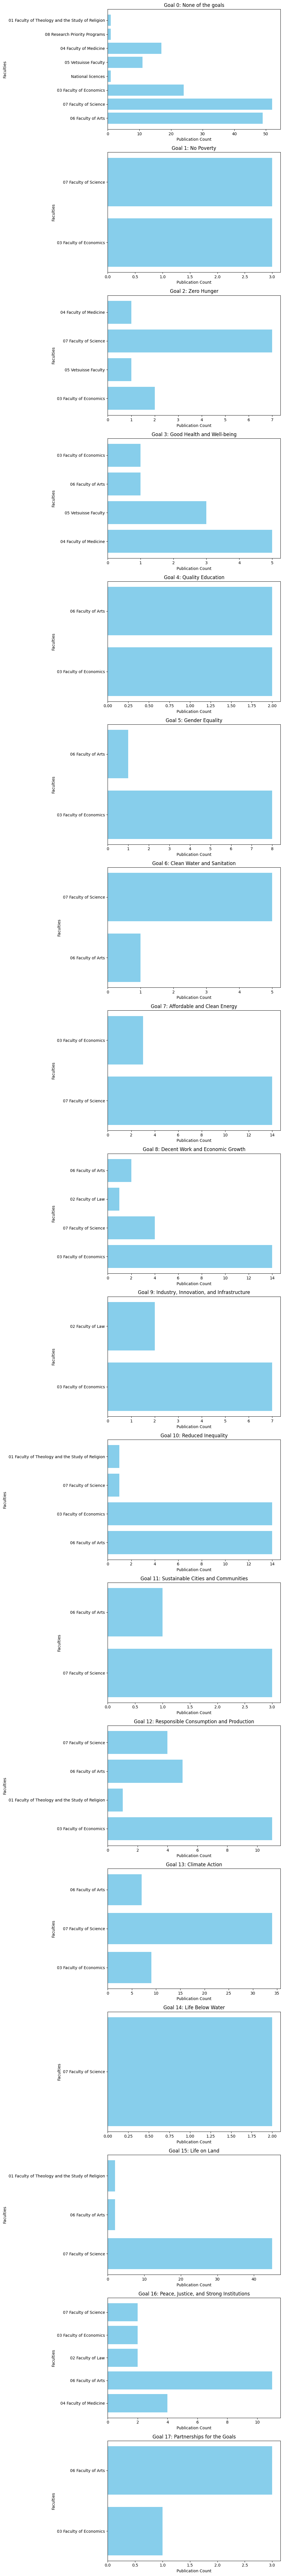

In [37]:
import matplotlib.pyplot as plt


goal_names = {
        "0": "None of the goals",
        "1": "No Poverty",
        "2": "Zero Hunger",
        "3": "Good Health and Well-being",
        "4": "Quality Education",
        "5": "Gender Equality",
        "6": "Clean Water and Sanitation",
        "7": "Affordable and Clean Energy",
        "8": "Decent Work and Economic Growth",
        "9": "Industry, Innovation, and Infrastructure",
        "10": "Reduced Inequality",
        "11": "Sustainable Cities and Communities",
        "12": "Responsible Consumption and Production",
        "13": "Climate Action",
        "14": "Life Below Water",
        "15": "Life on Land",
        "16": "Peace, Justice, and Strong Institutions",
        "17": "Partnerships for the Goals"
    }

# Create subplots
num_goals = len(cats_by_pap_count)
fig, axes = plt.subplots(nrows=num_goals, figsize=(10, 5 * num_goals))

# Check if there is only one goal to adjust indexing
if num_goals == 1:
    axes = [axes]

# Plotting each goal
for idx, (goal, faculties) in enumerate(cats_by_pap_count.items()):
    names = list(faculties.keys())
    values = list(faculties.values())

    axes[idx].barh(names, values, color='skyblue')
    axes[idx].set_title(f'Goal {goal}: {goal_names[f"{goal}"]}')
    axes[idx].set_xlabel('Publication Count')
    axes[idx].set_ylabel('Faculties')

# Show the plot
plt.tight_layout()
plt.show()